## Lymph Node Metastases Detection

#### Import necessary packages
 Used a modified "patch_camelyon" dataset from Kaggle

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image

#### Load Dataset

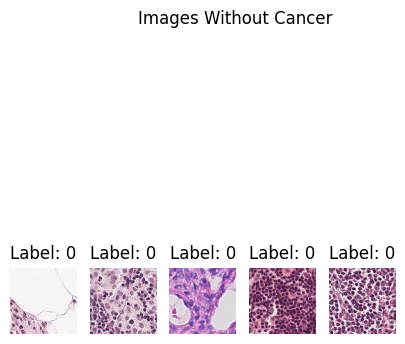

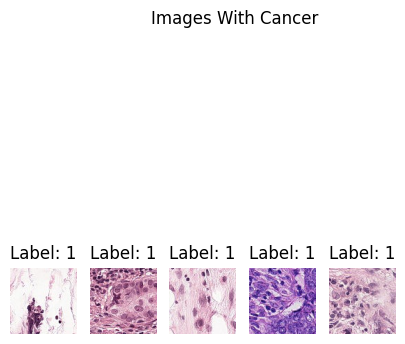

In [2]:
# Load the dataset
TRAIN_DIR = '/kaggle/input/histopathologic-cancer-detection/train'
TEST_DIR = '/kaggle/input/histopathologic-cancer-detection/test'

# Load train labels from CSV file
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')

# Image visualization from the dataset
def show_images(image_id, labels, path, title):
    plt.figure(figsize=(6,6))
    for i, (image, label) in enumerate(zip(image_id, labels)):
        img_path = os.path.join(path, image + '.tif')
        img = Image.open(img_path)
        plt.subplot(1, len(image_id), i+1)
        plt.imshow(img)
        plt.title(f"Label: {label}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_images(train_labels[train_labels['label'] == 0]['id'][:6], [0]*5, TRAIN_DIR, "Images Without Cancer")
show_images(train_labels[train_labels['label'] == 1]['id'][:6], [1]*5, TRAIN_DIR, "Images With Cancer")

#### Preprocess

In [3]:
# Apply the preprocess to the dataset
batch_size = 64
target_size = (32, 32)

train_datagen = ImageDataGenerator(
    rescale = 1./255, # Normalize
    validation_split = 0.25 # 25% validation data
)
# Convert label to string
train_labels['id'] = train_labels['id'].apply(lambda x: x + '.tif')
train_labels['label'] = train_labels['label'].astype(str)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_dataframe(
    dataframe=train_labels,
    directory=TRAIN_DIR,
    x_col='id',
    y_col='label',
    target_size=target_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


#### Model construction (Using Convolutional NN Model)

In [4]:
model = models.Sequential([
    layers.Conv2D(16, (3,3), activation="relu", input_shape=(32, 32, 3)), # Input shape is 32x32x3
    layers.MaxPooling2D(2,2),
    layers.Conv2D(32, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64, (3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid") # Binary classification
])
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

# Define callback
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 30, 30, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 15, 15, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 13, 13, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 6, 6, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 4, 4, 64)            │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,609 (221.13 KB)

 Trainable params: 56,609 (221.13 KB)

 Non-trainable params: 0 (0.00 B)

#### Model Training

In [5]:
# Model training
history = model.fit(
    train_generator, 
    epochs=20, 
    validation_data=validation_generator, 
    batch_size=batch_size, 
    callbacks=[early_stopping])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2579/2579 ━━━━━━━━━━━━━━━━━━━━ 1385s 535ms/step - accuracy: 0.7539 - loss: 0.5110 - val_accuracy: 0.8011 - val_loss: 0.4468
Epoch 2/20
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 694s 269ms/step - accuracy: 0.8032 - loss: 0.4370 - val_accuracy: 0.8195 - val_loss: 0.4034
Epoch 3/20
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 436s 169ms/step - accuracy: 0.8225 - loss: 0.4020 - val_accuracy: 0.8363 - val_loss: 0.3749
Epoch 4/20
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 423s 164ms/step - accuracy: 0.8327 - loss: 0.3808 - val_accuracy: 0.8411 - val_loss: 0.3641
Epoch 5/20
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 476s 184ms/step - accuracy: 0.8401 - loss: 0.3664 - val_accuracy: 0.8459 - val_loss: 0.3530
Epoch 6/20
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 485s 188ms/step - accuracy: 0.8451 - loss: 0.3541 - val_accuracy: 0.8434 - val_loss: 0.3515
Epoch 7/20
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 480s 186ms/step - accuracy: 0.8475 - loss: 0.3515 - val_accuracy: 0.8471 - val_loss: 0.3589
Epoch 8/20
2579/2579 ━━━━━━━━━━━━━━━━━━━━ 497s 192ms/step - accuracy: 0.

#### Model Evaluation and Graph Visualization

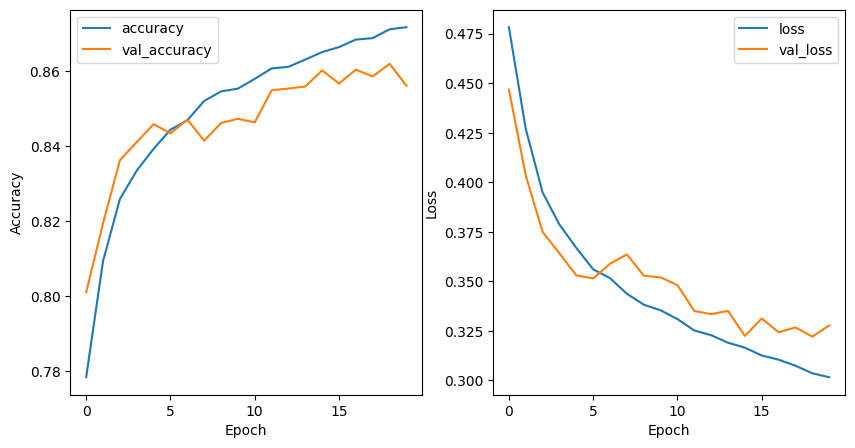

In [6]:
# Plot the training history
def plot_history(history):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

plot_history(history)

#### Submission Preparation

In [7]:
df_submission = pd.DataFrame({'id':os.listdir(TEST_DIR)})

test_datagen = ImageDataGenerator(rescale=1./255) # Normalize test dataset

test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_submission,
    directory=TEST_DIR,
    x_col='id',
    y_col=None,
    target_size=target_size,
    batch_size=batch_size,
    class_mode=None, # No labels (we are predicting)
    shuffle=False # Keep in order to match filenames
)

predictions = model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Add predictions to dataframe
df_submission['id'] = df_submission['id'].str.replace(".tif","",regex=False) # Remove extension
df_submission['label'] = predicted_labels
df_submission = df_submission[['id', 'label']]

print(df_submission.head())

df_submission.to_csv("submission.csv", index=False)

Found 57458 validated image filenames.
898/898 ━━━━━━━━━━━━━━━━━━━━ 331s 369ms/step
                                         id  label
0  a7ea26360815d8492433b14cd8318607bcf99d9e      1
1  59d21133c845dff1ebc7a0c7cf40c145ea9e9664      0
2  5fde41ce8c6048a5c2f38eca12d6528fa312cdbb      0
3  bd953a3b1db1f7041ee95ff482594c4f46c73ed0      1
4  523fc2efd7aba53e597ab0f69cc2cbded7a6ce62      0


#### Save model (optional)

In [8]:
# Save model
model.save('Histopathologic_Cancer_Model.h5')